In [1]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations
from scipy.spatial.distance import cdist

## Matching Approach Simulation

#### Limitations

After changing the decision variable weight $w_i$ as binary number and objective function into maximize the sample size, if I continue follow the weight balancing constraints, it means force the selected subset to exactly replicate the entire sample’s sum of covariates in the plus and minus group, the entire sample’s sum in the minus group, etc. This will be most likely infeasible if $w_i \in{0,1}$. It cannot pick a strict subset that exactly reproduces the entire sample’s sums.

Therefore, I allowed a tolerance on the SMD of the lhs and rhs for every balancing constraints. I calculated the SMD of the lhs and rhs of every balancing constraints and let them smaller than this tolerance value. For the heterogeneous constraints, I added a slack variable in the objective function with penalty to further relax the tolerance. 


In [2]:
np.random.seed(123)

D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

# assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments

# generate true main effects
def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="heterogeneous":
        meanY = Y_model_het(X, Z)
    elif model=="misspecified":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)

def solve_matching_additive(X, Z, tol=0.1):

    N, D = X.shape
    K = Z.shape[1]

    # Define group membership indicators
    Aplus = np.where(Z > 0, 1.0, 0.0)
    Aminus = 1.0 - Aplus

    # Full sample sums (for converting sums into means)
    sumX = np.sum(X, axis=0)
    # Standard deviation for each covariate (population std)
    std_X = np.std(X, axis=0, ddof=0)

    # Build the model
    model = gp.Model("AdditiveBalance_binary")
    model.setParam('OutputFlag', 0)

    # Decision variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")
    # Objective: maximize the number of selected units
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)), GRB.MAXIMIZE)

    # Relaxed balancing constraints for each factor and covariate dimension:
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i] * Aplus[i, k_] * X[i, d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i] * Aminus[i, k_] * X[i, d_] for i in range(N))
            # Instead of exact equality of sums, we require the difference in means to be within tol std deviations:
            model.addConstr((lhs_plus/N - sumX[d_]/N) / std_X[d_] <= tol)
            model.addConstr((lhs_plus/N - sumX[d_]/N) / std_X[d_] >= -tol)
            model.addConstr((lhs_minus/N - sumX[d_]/N) / std_X[d_] <= tol)
            model.addConstr((lhs_minus/N - sumX[d_]/N) / std_X[d_] >= -tol)

    # Relaxed interaction constraints:
    # For interactions up to order K_prime (here set as min(K,2) as in your original code)
    K_prime = min(K, 3)
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    factor = 1 / (2**(K - 1))
    for k_size in range(2, K_prime + 1):
        for J in combinations(range(K), k_size):
            # Compute the interaction for each individual:
            Z_interaction = np.prod(Z[:, list(J)], axis=1)
            lhs = gp.quicksum(w_vars[i] * Z_interaction[i] for i in range(N))
            # Compute the target value:
            g_interaction = np.prod(Z_all[:, list(J)], axis=1)
            rhs = factor * np.sum(g_interaction)
            # Compute standard deviation of the interaction variable (over full sample)
            std_interaction = np.std(Z_interaction, ddof=0)
            # Relax the equality constraint using tol (scaled back to the sum scale)
            model.addConstr((lhs/N - rhs/N)/ std_interaction <= tol)
            model.addConstr((lhs/N - rhs/N)/ std_interaction <= tol)
            
    # Solve the model
    model.optimize()
    if model.status != GRB.OPTIMAL:
        #print("Binary additive-balance model infeasible or no optimal solution found.")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def solve_matching_heterogeneous(X, Z, tol=1.0, lambda_penalty=100.0):

    N, D = X.shape
    K = Z.shape[1]

    model = gp.Model("HeteroBinary")
    model.setParam('OutputFlag', 0)

    # Decision variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")

    basis_vals = [np.ones(N)]
    for d_ in range(D):
        basis_vals.append(X[:, d_])
    # Treatment groupings: intercept and main effects (can be extended)
    J_list = [()] + [(j,) for j in range(K)]
    n_s = len(basis_vals)
    n_J = len(J_list)

    # Precompute Qvals for each unit, basis function, and treatment grouping.
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0:
            Zp = np.ones(N)
        else:
            Zp = np.prod(Z[:, list(J_)], axis=1)
        for s_ in range(n_s):
            Qvals[:, s_, j_idx] = basis_vals[s_] * Zp

    # Compute target values over all treatment combinations.
    Aplus = np.where(Z > 0, 1.0, 0.0)
    Aminus = 1.0 - Aplus
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_index, z_ in enumerate(Z_all):
        for j_idx, J_ in enumerate(J_list):
            z_prod = np.prod(z_[list(J_)])
            for s_ in range(n_s):
                bigQ[z_index, s_, j_idx] = z_prod * np.sum(basis_vals[s_])
    factor = 1.0 / (2.0**(K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))
    for k_ in range(K):
        for z_index, z_ in enumerate(Z_all):
            if z_[k_] == +1:
                coeff_plus = 1.0
                coeff_minus = 0.0
            else:
                coeff_plus = 0.0
                coeff_minus = 1.0
            for s_ in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k_, s_, j_idx] += factor * coeff_plus * bigQ[z_index, s_, j_idx]
                    target_minus[k_, s_, j_idx] += factor * coeff_minus * bigQ[z_index, s_, j_idx]

    # List to collect slack variables.
    slack_vars = []
    for k_ in range(K):
        for s_ in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                # Compute standard deviations over full sample:
                values_plus = Aplus[:, k_] * Qvals[:, s_, j_idx]
                std_plus = np.std(values_plus, ddof=0)
                values_minus = Aminus[:, k_] * Qvals[:, s_, j_idx]
                std_minus = np.std(values_minus, ddof=0)

                # Slack variables for plus side
                s_plus = model.addVar(lb=0, name=f"s_plus_{k_}_{s_}_{j_idx}")
                s_minus = model.addVar(lb=0, name=f"s_minus_{k_}_{s_}_{j_idx}")
                slack_vars.extend([s_plus, s_minus])
                model.addConstr((lhs_plus / N - target_plus[k_, s_, j_idx] / N) / std_plus <= tol + s_plus)
                model.addConstr((lhs_plus / N - target_plus[k_, s_, j_idx] / N) / std_plus >= -tol - s_minus)

                # Slack variables for minus side
                s_plus_m = model.addVar(lb=0, name=f"s_plus_m_{k_}_{s_}_{j_idx}")
                s_minus_m = model.addVar(lb=0, name=f"s_minus_m_{k_}_{s_}_{j_idx}")
                slack_vars.extend([s_plus_m, s_minus_m])
                model.addConstr((lhs_minus / N - target_minus[k_, s_, j_idx] / N) / std_minus <= tol + s_plus_m)
                model.addConstr((lhs_minus / N - target_minus[k_, s_, j_idx] / N) / std_minus >= -tol - s_minus_m)

    obj = gp.quicksum(w_vars[i] for i in range(N)) - lambda_penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, GRB.MAXIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

    
#  Do an naive difference in means for each factor to estimate the factorial effect
def estimate_main_effects_matched(Y, Z, match_vec):
    # Weighted means become simple means if match_vec is 0/1
    # tau_k = mean(Y | Z_k=+1 & matched) - mean(Y | Z_k=-1 & matched)
    tau_est_matched = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1) & (match_vec == 1)
        minus_mask = (Z[:, k_] == -1) & (match_vec == 1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est_matched[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est_matched[k_+1] = mean_plus - mean_minus
    return tau_est_matched


# Getting the standardized mean difference (SMD) for each factor k and each covariate dimension d
def get_covariate_balance_matched(X, Z, selection):
    sd_X = np.std(X, axis=0, ddof=1)
    smd = np.zeros((K, D))
    for k in range(K):
        plus_mask = (Z[:, k] == +1) & (selection == 1)
        minus_mask = (Z[:, k] == -1) & (selection == 1)
        if np.sum(plus_mask) > 0:
            mean_plus = np.mean(X[plus_mask], axis=0)
        else:
            mean_plus = np.full(X.shape[1], np.nan)
        if np.sum(minus_mask) > 0:
            mean_minus = np.mean(X[minus_mask], axis=0)
        else:
            mean_minus = np.full(X.shape[1], np.nan)
        diff = mean_plus - mean_minus
        smd[k, :] = diff / (sd_X + 1e-15)
    return smd


# print an array with 5 significant figures per float.
def print_array_5sig(arr):
    with np.printoptions(formatter={'float_kind': lambda x: f"{x:.5g}"}):
        print(arr)

def run_all_simulations(n_sims=100, N=500, tol_add=0.1, tol_het=0.1, lambda_penalty=1000000.0):
    # Outcome models for RMSE simulation.
    outcome_models = ["additive", "heterogeneous", "misspecified"]
    # Containers for squared error for each outcome model and matching method.
    rmse_sq_results = {model: {"add": [], "het": []} for model in outcome_models}
    
    # Containers for SMD.
    orig_smd_list = []
    smd_add_list = []
    smd_het_list = []
    
    # Containers for ESS.
    ess_add_list = []
    ess_het_list = []
    
    # Loop over simulations.
    for sim in range(n_sims):
        # Generate covariates and treatments.
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_ = generate_treatments(Xraw)
        
        # Compute original covariate balance (SMD) using all units.
        orig_smd = get_covariate_balance_matched(Xraw, Z_, np.ones(N))
        orig_smd_list.append(orig_smd)
        
        # Compute matching solutions.
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het, lambda_penalty=lambda_penalty)
        
        # SMD after additive matching.
        if matchA is not None:
            smd_add = get_covariate_balance_matched(Xraw, Z_, matchA)
        else:
            smd_add = np.full((K, D), np.nan)
        smd_add_list.append(smd_add)
        
        # SMD after heterogeneous matching.
        if matchH is not None:
            smd_het = get_covariate_balance_matched(Xraw, Z_, matchH)
        else:
            smd_het = np.full((K, D), np.nan)
        smd_het_list.append(smd_het)
        
        # Compute effective sample sizes.
        ess_add = np.sum(matchA) if matchA is not None else np.nan
        ess_het = np.sum(matchH) if matchH is not None else np.nan
        ess_add_list.append(ess_add)
        ess_het_list.append(ess_het)
        
        # For each outcome model, simulate Y and compute squared errors for the three main effects.
        for mtype in outcome_models:
            Y_ = simulate_Y(Xraw, Z_, model=mtype)
            
            # Get the true outcome function.
            if mtype == "additive":
                Yfn = Y_model_additive
            elif mtype == "heterogeneous":
                Yfn = Y_model_het
            elif mtype == "misspecified":
                Yfn = Y_model_mis
            true_tau = true_main_effects(Yfn)
            
            # Define the indices for the three main effects (assuming indices 1, 2, and 3).
            true_effects = np.array([true_tau[1], true_tau[2], true_tau[3]])
            
            # Additive matching error.
            if matchA is not None:
                tA = estimate_main_effects_matched(Y_, Z_, matchA)
                effects_est_A = np.array([tA[1], tA[2], tA[3]])
                sq_error_A = (effects_est_A - true_effects) ** 2
            else:
                sq_error_A = np.array([np.nan, np.nan, np.nan])
            rmse_sq_results[mtype]["add"].append(sq_error_A)
            
            # Heterogeneous matching error.
            if matchH is not None:
                tH = estimate_main_effects_matched(Y_, Z_, matchH)
                effects_est_H = np.array([tH[1], tH[2], tH[3]])
                sq_error_H = (effects_est_H - true_effects) ** 2
            else:
                sq_error_H = np.array([np.nan, np.nan, np.nan])
            rmse_sq_results[mtype]["het"].append(sq_error_H)
    
    # Aggregate RMSE by taking the square root of the mean squared error for each effect.
    aggregated_rmse = {}
    for mtype in outcome_models:
        rmse_add = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["add"]), axis=0))
        rmse_het = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["het"]), axis=0))
        aggregated_rmse[mtype] = {
            "true_tau": true_tau,  # Assuming true_tau remains constant across simulations.
            "rmse_add": rmse_add,
            "rmse_het": rmse_het
        }
    
    # Aggregate SMD.
    aggregated_smd = {
        "mean_orig_smd": np.nanmean(np.array(orig_smd_list), axis=0),
        "mean_smd_add": np.nanmean(np.array(smd_add_list), axis=0),
        "mean_smd_het": np.nanmean(np.array(smd_het_list), axis=0)
    }
    
    # Aggregate ESS.
    aggregated_ess = {
        "mean_ess_add": np.nanmean(np.array(ess_add_list)),
        "mean_ess_het": np.nanmean(np.array(ess_het_list))
    }
    
    # Return the combined simulation results.
    simulation_results = {
        "rmse": aggregated_rmse,
        "smd": aggregated_smd,
        "ess": aggregated_ess
    }
    return simulation_results



In [8]:
np.random.seed(123)

if __name__ == "__main__":
    simulation_dict = run_all_simulations(n_sims=50, N=200, tol_add=0.02, tol_het=0.01, lambda_penalty=100000.0)
    
    # Print RMSE results (by outcome model).
    print("RMSE Results (by outcome model):")
    for mtype in simulation_dict["rmse"]:
        print(f"Model {mtype}:")
        print("True main effects:", simulation_dict["rmse"][mtype]['true_tau'])
        print("RMSE (additive matching):", simulation_dict["rmse"][mtype]["rmse_add"])
        print("RMSE (heterogeneous matching):", simulation_dict["rmse"][mtype]["rmse_het"])
    
    # Print SMD results.
    print("\nSMD Results:")
    print("Original covariate SMD:")
    print_array_5sig(simulation_dict["smd"]["mean_orig_smd"])
    print("\nSMD after additive matching:")
    print_array_5sig(simulation_dict["smd"]["mean_smd_add"])
    print("\nSMD after heterogeneous matching:")
    print_array_5sig(simulation_dict["smd"]["mean_smd_het"])
    
    # Print ESS results.
    print("\nEffective Sample Size Results:")
    print("ESS (additive matching):", simulation_dict["ess"]["mean_ess_add"])
    print("ESS (heterogeneous matching):", simulation_dict["ess"]["mean_ess_het"])


RMSE Results (by outcome model):
Model additive:
True main effects: {1: np.float64(0.2068657394697227), 2: np.float64(0.6078847784303618), 3: np.float64(0.6078847784303618)}
RMSE (additive matching): [0.0457728  0.58719798 0.49280455]
RMSE (heterogeneous matching): [1.31654316 1.50707177 1.42826936]
Model heterogeneous:
True main effects: {1: np.float64(0.2068657394697227), 2: np.float64(0.6078847784303618), 3: np.float64(0.6078847784303618)}
RMSE (additive matching): [0.99457867 0.79737419 1.74688677]
RMSE (heterogeneous matching): [1.77344114 1.9916596  1.87429278]
Model misspecified:
True main effects: {1: np.float64(0.2068657394697227), 2: np.float64(0.6078847784303618), 3: np.float64(0.6078847784303618)}
RMSE (additive matching): [0.47236135 0.93922063 1.11271608]
RMSE (heterogeneous matching): [0.67659955 0.96586843 1.07473633]

SMD Results:
Original covariate SMD:
[[0.17924 0.3968 0.018213 0.56633 0.70778]
 [0.54674 0.17663 0.73611 0.0073278 0.35243]
 [0.73927 -0.038697 0.52625 

### The plots

#### The plot of the root mean squared error (RMSE) for estimating three main effects using two estimators matched additive and matched heterogeneous with n_sims=50, N=200, tol_add=0.02, tol_het=0.01 and lambda_penalty=100000

#### The plot of the standardized mean differences(SMDs) for estimating three main effects using two estimators matched additive and matched heterogeneous with n_sims=50, N=200, tol_add=0.02, tol_het=0.01 and lambda_penalty=100000

#### The plot of the selected effective sample size(ESS) for estimating three main effects using two estimators matched additive and matched heterogeneous with n_sims=50, N=200, tol_add=0.02, tol_het=0.01 and lambda_penalty=100000

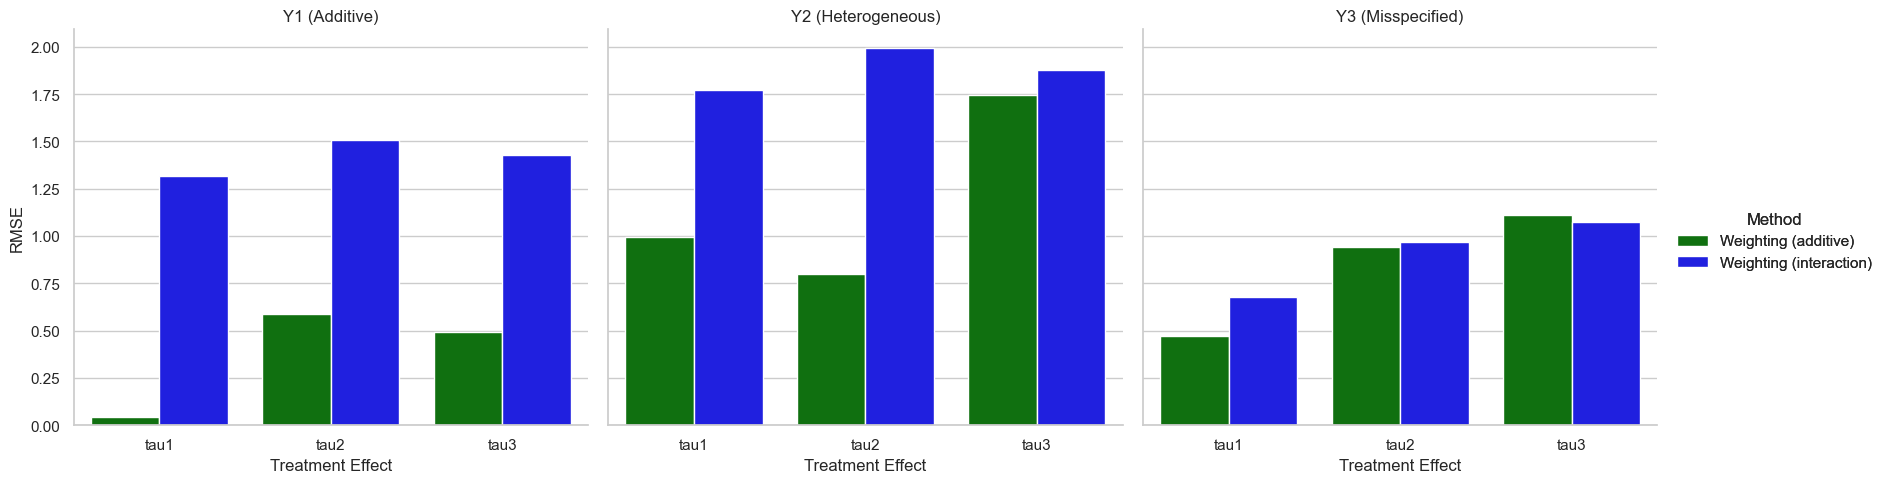

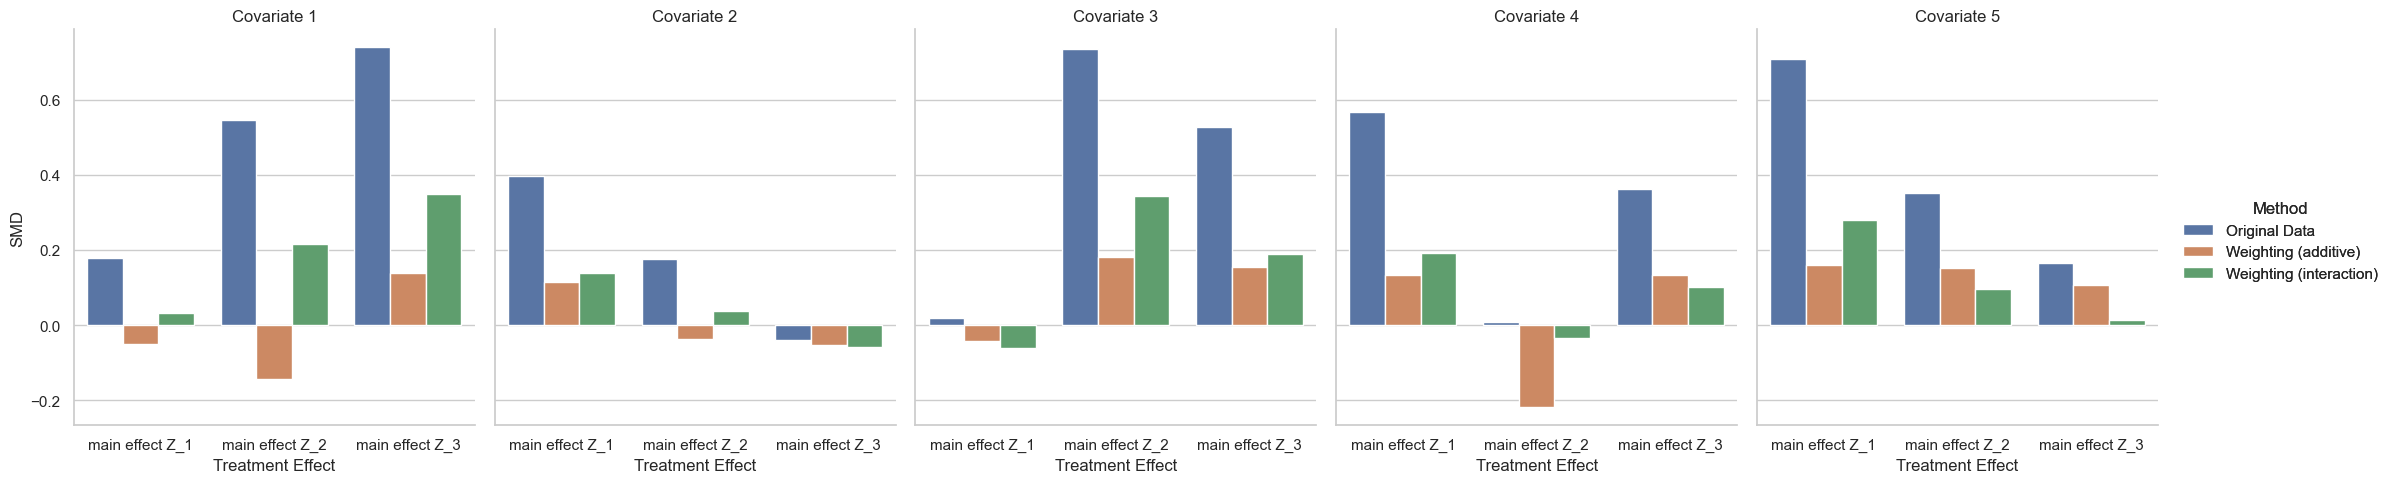

/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_18012/2220430623.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_ess = sns.catplot(


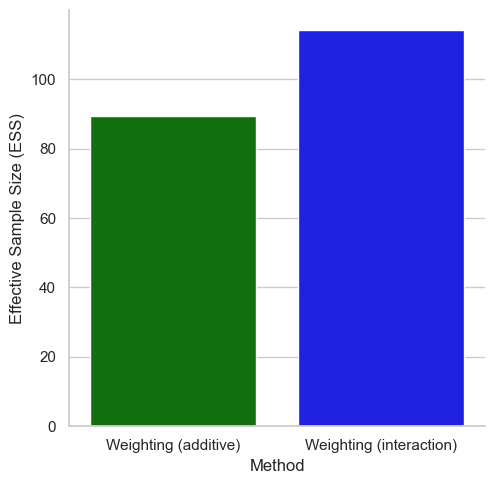

In [9]:
def plot_simulation_results(simulation_dict):
    rmse_results = simulation_dict["rmse"]
    effects = ['tau1', 'tau2', 'tau3']
    methods = ["rmse_add", "rmse_het"]
    method_names = ["Weighting (additive)", "Weighting (interaction)"]
    models = {"additive": "Y1 (Additive)", 
              "heterogeneous": "Y2 (Heterogeneous)", 
              "misspecified": "Y3 (Misspecified)"}
    
    data_rmse = []
    # Loop over outcome models (each contains keys "rmse_add" and "rmse_het").
    for model_type, res in rmse_results.items():
        for method, mname in zip(methods, method_names):
            # Each RMSE array is assumed to be of shape (3,) corresponding to tau1, tau2, tau3.
            rmse_values = res[method]
            for i, eff in enumerate(effects):
                data_rmse.append([models[model_type], eff, rmse_values[i], mname])
    
    df_rmse = pd.DataFrame(data_rmse, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    sns.set(style="whitegrid")
    g_rmse = sns.catplot(
        data=df_rmse,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['green', 'blue'],
        height=5,
        aspect=1
    )
    g_rmse.set_axis_labels("Treatment Effect", "RMSE")
    g_rmse.set_titles("{col_name}")
    g_rmse.set_xticklabels(rotation=0)
    g_rmse.add_legend(title="Method")
    plt.show()
    
    smd_results = simulation_dict["smd"]
    effects_smd = ['main effect Z_1', 'main effect Z_2', 'main effect Z_3']
    methods_smd = ["Original Data", "Weighting (additive)", "Weighting (interaction)"]
    keys_smd = ["mean_orig_smd", "mean_smd_add", "mean_smd_het"]
    
    data_smd = []
    for key, method_name in zip(keys_smd, methods_smd):
        smd_values = smd_results[key]  # assumed shape (3, D)
        n_effects, n_cov = smd_values.shape
        for i in range(n_effects):
            for j in range(n_cov):
                data_smd.append([effects_smd[i], f"Covariate {j+1}", smd_values[i, j], method_name])
    
    df_smd = pd.DataFrame(data_smd, columns=["Effect", "Covariate", "SMD", "Method"])
    
    sns.set(style="whitegrid")
    g_smd = sns.catplot(
        data=df_smd,
        x="Effect",
        y="SMD",
        hue="Method",
        col="Covariate",
        kind="bar",
        height=5,
        aspect=0.8
    )
    g_smd.set_axis_labels("Treatment Effect", "SMD")
    g_smd.set_titles("{col_name}")
    g_smd.add_legend(title="Method")
    plt.show()
    
    ess_results = simulation_dict["ess"]
    methods_ess = ["Weighting (additive)", "Weighting (interaction)"]
    keys_ess = ["mean_ess_add", "mean_ess_het"]
    
    data_ess = []
    for key, method_name in zip(keys_ess, methods_ess):
        data_ess.append(["ESS", method_name, ess_results[key]])
    
    df_ess = pd.DataFrame(data_ess, columns=["Metric", "Method", "ESS"])
    
    sns.set(style="whitegrid")
    g_ess = sns.catplot(
        data=df_ess,
        x="Method",
        y="ESS",
        kind="bar",
        palette=['green', 'blue'],
        height=5,
        aspect=1
    )
    g_ess.set_axis_labels("Method", "Effective Sample Size (ESS)")
    g_ess.add_legend()
    plt.show()

plot_simulation_results(simulation_dict)

## Setup 2

### Approach:


I stratified the selected samples into several groups (strata) and within each stratum, the distribution of covariates is balanced across treatment levels. The method forces that, within each stratum, the means and interactions of the covariates for units receiving “+1” and “–1” treatments to be very similar (within a specified tolerance). 

I start with a dataset of N selected units, each with 5 covariates (stored in X) and a set of 3 treatment indicators (stored in Z, with entries either +1 or –1). The goal is to assign every unit to one of a fixed number of strata (S strata) such that within each stratum the covariate distributions between the treatment groups (for each factor and for interactions like the ones in the balancing weight method) are similar to the overall distribution. There are additive approach and heterogeneous approach.

##### Decision Variables:
Let:
- $N$: Number of units
- $D$: Number of covariates
- $K$: Number of treatment factors
- $S$: Number of strata (fixed)


For each unit $i$ = 1, $\dots$, N and stratum $s$ = 1, $\dots$, S, define:
$$
S_{i,s} \in \{0, 1\}
$$
- $S_{i,s}$ = 1 if unit $i$ is assigned to stratum $s$.
- Constraint: Each unit is assigned to exactly one stratum:
$
\sum_{s=1}^{S} S_{i,s} = 1 \quad \forall i
$


Slack variables allow relaxed constraints:
- For each balancing constraint, introduce:
$
\text{sp}_{\text{plus}}, \text{sm}_{\text{plus}}, \text{sp}_{\text{minus}}, \text{sm}_{\text{minus}} \geq 0
$


##### Balancing Constraints:

Balance is required within each stratum for covariates and for interactions.

Main Effects: For each stratum $s$, treatment $k$, and covariate $d$:

Let:
- $ A^+_{i,k} = \mathbb{1}\{Z_{i,k} = +1\} $
- $ A^-_{i,k} = 1 - A^+_{i,k}$
- $\mu_d = \frac{1}{N} \sum_{i=1}^{N} X_{i,d} $
- $ \sigma_d = \text{std}(X_{\cdot, d}) $

The balance constraints (with slack):
$$
\frac{1}{N \sigma_d} \left( \sum_{i} S_{i,s} A^+_{i,k} X_{i,d} - N \mu_d \right) \leq \text{tol} + \text{sp}_{\text{plus}}
$$
$$
\frac{1}{N \sigma_d} \left( \sum_{i} S_{i,s} A^+_{i,k} X_{i,d} - N \mu_d \right) \geq -\text{tol} - \text{sm}_{\text{plus}}
$$
and similarly for the minus group.

Interaction Effects: Let $J \subset \{1, \dots, K\} $ be a subset of treatment factors. Define interaction:
$
Z^{(J)}_i = \prod_{j \in J} Z_{i,j}
$

Let:
- $ Z_{\text{all}} \in \{-1,1\}^{2^K \times K} $: All possible treatment vectors
- $ \text{target}_J = \frac{1}{2^{K-1}} \sum_{z \in Z_{\text{all}}} \prod_{j \in J} z_j $

Then the constraint for interactions becomes:
$$
\frac{1}{N \cdot \sigma_J} \left( \sum_{i=1}^N S_{i,s} Z^{(J)}_i - N \cdot \text{target}_J \right) \leq \text{tol} + \text{sp}_{\text{inter}}
$$
$$
\frac{1}{N \cdot \sigma_J} \left( \sum_{i=1}^N S_{i,s} Z^{(J)}_i - N \cdot \text{target}_J \right) \geq -\text{tol} - \text{sm}_{\text{inter}}
$$

##### Objective Function:

I set the goal to minimize imbalance, represented by the sum of slack variables.

Additive Objective:
$$
\min \sum \text{all slack variables}
$$

Heterogeneous Objective:

Uses a penalty parameter $\lambda $ to scale imbalance,
$$
\min \lambda \cdot \sum \text{all slack variables}
$$

This encourages tighter balance but allows flexibility when necessary.


##### Solution and Output:

- A MILP is solved using Gurobi.
- The solution yields a stratum assignment $ S_{i,s} \in \{0,1\} $, which is converted into a single stratum label for each unit.
- After assignment, Standardized Mean Differences (SMDs) can be computed for each stratum to evaluate balance:
  $
  \text{SMD}_{k,d} = \frac{\bar{X}_{+,k,d} - \bar{X}_{-,k,d}}{\text{std}(X_{\cdot,d})}
  $

Right now the smd of each strata is very high because the tolerance and penalty term is very big. If I make the tolerance smaller, I get all infeasible outputs.

In [11]:
def solve_strata_additive(X, Z, num_strata=5, tol=0.1):
    """
    Revised additive strata solver.
    Instead of maximizing the number of used strata,
    this version minimizes the total imbalance (sum of slack variables).
    """
    N, D = X.shape
    K = Z.shape[1]

    # Binary coding for treatment: 1 if positive, 0 if not.
    Aplus  = (Z > 0).astype(float) 
    Aminus = 1.0 - Aplus

    # Overall totals for X and standard deviations (for normalization)
    sumX = np.sum(X, axis=0)
    std_X = np.std(X, axis=0, ddof=0)

    model = gp.Model("StrataAdditive")
    model.setParam('OutputFlag', 0)

    # Decision variables: assignment of each unit i to stratum s.
    S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")

    # Every unit must be assigned to exactly one stratum.
    for i in range(N):
        model.addConstr(gp.quicksum(S[i, s] for s in range(num_strata)) == 1)

    # List to collect slack variables.
    slack_vars = []

    # --- Balancing constraints for main effects ---
    # For each stratum, for each treatment factor k, and for each covariate d:
    for s in range(num_strata):
        for k in range(K):
            for d in range(D):
                # Compute weighted sum of X for units in stratum s.
                lhs_plus = gp.quicksum(S[i, s] * Aplus[i, k]  * X[i, d] for i in range(N))
                lhs_minus = gp.quicksum(S[i, s] * Aminus[i, k] * X[i, d] for i in range(N))
                
                # For the “plus” side, introduce two nonnegative slack variables.
                sp_plus = model.addVar(lb=0.0, name=f"sp_plus_s{s}_k{k}_d{d}")
                sm_plus = model.addVar(lb=0.0, name=f"sm_plus_s{s}_k{k}_d{d}")
                slack_vars.extend([sp_plus, sm_plus])
                # Normalized difference for plus side.
                expr_plus = (lhs_plus / N - sumX[d] / N) / std_X[d]
                model.addConstr(expr_plus <= tol + sp_plus)
                model.addConstr(expr_plus >= -tol - sm_plus)
                
                # For the “minus” side, similarly add slack.
                sp_minus = model.addVar(lb=0.0, name=f"sp_minus_s{s}_k{k}_d{d}")
                sm_minus = model.addVar(lb=0.0, name=f"sm_minus_s{s}_k{k}_d{d}")
                slack_vars.extend([sp_minus, sm_minus])
                expr_minus = (lhs_minus / N - sumX[d] / N) / std_X[d]
                model.addConstr(expr_minus <= tol + sp_minus)
                model.addConstr(expr_minus >= -tol - sm_minus)
    
    # For interactions up to order K_prime = min(K,2):
    K_prime = min(K, 2)
    Z_all = np.array(list(product([-1, 1], repeat=K)))  # all combinations of ±1
    factor = 1 / (2 ** (K - 1))
    for k_size in range(2, K_prime + 1):
        for J in combinations(range(K), k_size):
            # For each unit, compute the product of the relevant Z entries.
            Z_interaction = np.prod(Z[:, list(J)], axis=1)
            # Compute a target sum as in your original code.
            g_interaction = np.prod(Z_all[:, list(J)], axis=1)
            rhs_sum = factor * np.sum(g_interaction)
            std_interaction = np.std(Z_interaction, ddof=0)
            for s in range(num_strata):
                lhs_stratum = gp.quicksum(S[i, s] * Z_interaction[i] for i in range(N))
                # Introduce slack for the interaction constraint.
                sp_inter = model.addVar(lb=0.0, name=f"sp_inter_s{s}_J{J}")
                sm_inter = model.addVar(lb=0.0, name=f"sm_inter_s{s}_J{J}")
                slack_vars.extend([sp_inter, sm_inter])
                expr_inter = (lhs_stratum / N - rhs_sum / N) / std_interaction
                model.addConstr(expr_inter <= tol + sp_inter)
                model.addConstr(expr_inter >= -tol - sm_inter)

    # --- New Objective: Minimize total imbalance (sum of all slack variables) ---
    model.setObjective(gp.quicksum(slack_vars), GRB.MINIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        return None

    # Extract the chosen stratum for each unit.
    S_sol = np.zeros(N, dtype=int)
    for i in range(N):
        for s in range(num_strata):
            if S[i, s].X > 0.5:
                S_sol[i] = s
                break

    return S_sol

def solve_strata_hetero(X, Z, num_strata=5, tol=1.0, lambda_penalty=100.0):
    model = gp.Model("StrataHeteroDiffSums_slack")
    model.setParam('OutputFlag', 0)

    N, D = X.shape
    K = Z.shape[1]

    # Decision variables: S[i,s] = assignment of unit i to stratum s.
    S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")
    # Also define the size of each stratum.
    stratum_size = model.addVars(num_strata, lb=0.0, name="stratum_size")

    # Each unit must be assigned to exactly one stratum.
    for i in range(N):
        model.addConstr(gp.quicksum(S[i, s] for s in range(num_strata)) == 1)
    for s in range(num_strata):
        model.addConstr(stratum_size[s] == gp.quicksum(S[i, s] for i in range(N)),
                        name=f"size_def_{s}")

    # Build the basis functions: intercept and covariates.
    basis_vals = [np.ones(N)]
    for d in range(D):
        basis_vals.append(X[:, d])
    n_s = len(basis_vals)

    # List of indices for main effects: intercept and each factor.
    J_list = [()] + [(k,) for k in range(K)]
    n_J = len(J_list)

    # Precompute Qvals[i, s_idx, j_idx] = basis_vals[s_idx][i] * (product of Z[i,j] for j in J)
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0:
            Zp = np.ones(N)
        else:
            Zp = np.prod(Z[:, list(J_)], axis=1)
        for s_idx in range(n_s):
            Qvals[:, s_idx, j_idx] = basis_vals[s_idx] * Zp

    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    # Build global targets as in your original code.
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_index, z_ in enumerate(Z_all):
        for j_idx, J_ in enumerate(J_list):
            if len(J_) == 0:
                z_prod = 1
            else:
                z_prod = np.prod(z_[list(J_)])
            for s_idx in range(n_s):
                bigQ[z_index, s_idx, j_idx] = z_prod * np.sum(basis_vals[s_idx])
    factor_ = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))
    for k in range(K):
        for z_index, z_ in enumerate(Z_all):
            if z_[k] == +1:
                coeff_plus  = 1.0
                coeff_minus = 0.0
            else:
                coeff_plus  = 0.0
                coeff_minus = 1.0
            for s_idx in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k, s_idx, j_idx]  += factor_ * coeff_plus  * bigQ[z_index, s_idx, j_idx]
                    target_minus[k, s_idx, j_idx] += factor_ * coeff_minus * bigQ[z_index, s_idx, j_idx]

    slack_vars = []
    

    # For each factor, basis, and main effect target, add constraints with slack.
    for k in range(K):
        for s_idx in range(n_s):
            for j_idx in range(n_J):
                for s in range(num_strata):
                    lhs_plus_s = gp.quicksum(S[i, s] * Aplus[i, k] * Qvals[i, s_idx, j_idx] for i in range(N))
                    lhs_minus_s = gp.quicksum(S[i, s] * Aminus[i, k] * Qvals[i, s_idx, j_idx] for i in range(N))
                    std_plus = np.std(Aplus[:, k] * Qvals[:, s_idx, j_idx], ddof=0)
                    std_minus = np.std(Aminus[:, k] * Qvals[:, s_idx, j_idx], ddof=0)
                    tar_plus = target_plus[k, s_idx, j_idx] * (stratum_size[s] / N)
                    tar_minus = target_minus[k, s_idx, j_idx] * (stratum_size[s] / N)
                    
                    sp_plus = model.addVar(lb=0.0, name=f"sp_plus_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    sm_plus = model.addVar(lb=0.0, name=f"sm_plus_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    sp_minus = model.addVar(lb=0.0, name=f"sp_minus_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    sm_minus = model.addVar(lb=0.0, name=f"sm_minus_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    slack_vars.extend([sp_plus, sm_plus, sp_minus, sm_minus])
                    
                    expr_plus = (lhs_plus_s - tar_plus) / std_plus
                    expr_minus = (lhs_minus_s - tar_minus) / std_minus
                    model.addConstr(expr_plus <= tol + sp_plus)
                    model.addConstr(expr_plus >= -tol - sm_plus)
                    model.addConstr(expr_minus <= tol + sp_minus)
                    model.addConstr(expr_minus >= -tol - sm_minus)

    # --- New Objective: minimize the weighted total slack (imbalance) ---
    # (Since each unit is always assigned, the sum of S is constant.)
    obj = lambda_penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Infeasible or no optimal solution found.")
        return None

    strata_assign = np.zeros(N, dtype=int)
    for i in range(N):
        for s in range(num_strata):
            if S[i, s].X > 0.5:
                strata_assign[i] = s
                break

    return strata_assign

# ----- Helper Function to Compute SMDs within Each Stratum -----
def get_strata_smds(X, Z, clusters):
    N, D = X.shape
    K = Z.shape[1]
    # Overall standard deviation for each covariate (for SMD normalization)
    sd_X = np.std(X, axis=0, ddof=1)
    strata = np.unique(clusters)
    strata_smd = {}
    for s in strata:
        sel = (clusters == s)
        smd = np.zeros((K, D))
        for k in range(K):
            # Masks for units with treatment +1 and -1 in factor k, within stratum s:
            plus_mask = (Z[:, k] == 1) & sel
            minus_mask = (Z[:, k] == -1) & sel
            if np.sum(plus_mask) > 0:
                mean_plus = np.mean(X[plus_mask], axis=0)
            else:
                mean_plus = np.full(D, np.nan)
            if np.sum(minus_mask) > 0:
                mean_minus = np.mean(X[minus_mask], axis=0)
            else:
                mean_minus = np.full(D, np.nan)
            diff = mean_plus - mean_minus
            smd[k, :] = diff / (sd_X + 1e-15)
        strata_smd[s] = smd
    return strata_smd


def run_simulation_matching_strata(n_sims=50, N=200, tol_add=0.05, tol_het=0.05, tol_add_strata =1, tol_het_strata=1,lambda_penalty=100.0,num_strata=5):
    simulation_results = []

    for sim in range(n_sims):
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)  # 'Sigma' from your global context
        Z_ = generate_treatments(Xraw)   # your function that returns +/-1 for each factor

        #    (Additive & Heterogeneous)
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het, lambda_penalty=10000.0)

        # Convert 'matchA' (which is a 0/1 array) to selected indices:
        if matchA is not None:
            selected_indices_A = np.flatnonzero(matchA > 0.5)
            X_selected_A = Xraw[selected_indices_A, :]
            Z_selected_A = Z_[selected_indices_A, :]
        else:
            selected_indices_A = np.array([], dtype=int)

        if matchH is not None:
            selected_indices_H = np.flatnonzero(matchH > 0.5)
            X_selected_H = Xraw[selected_indices_H, :]
            Z_selected_H = Z_[selected_indices_H, :]
        else:
            selected_indices_H = np.array([], dtype=int)

        #    (Additive & Heterogeneous w/ slack)
        # These functions assign every unit to exactly 1 stratum if feasible.
        assignment_A = solve_strata_additive(X_selected_A, Z_selected_A, num_strata=num_strata, tol=tol_add_strata)
        assignment_H = solve_strata_hetero(X_selected_H, Z_selected_H, num_strata=num_strata,
                                                           tol=tol_het_strata, lambda_penalty=lambda_penalty)
        # Calculate SMDs within each stratum for strata-based solutions
        strata_smd_A = get_strata_smds(X_selected_A, Z_selected_A, assignment_A) if assignment_A is not None else {}
        strata_smd_H = get_strata_smds(X_selected_H, Z_selected_H, assignment_H) if assignment_H is not None else {}
        sim_result = {
            "X": Xraw,
            "Z": Z_,
            # weighting-based
            "matchA": matchA,                     # 0/1 array or None
            "matchH": matchH,                     # 0/1 array or None
            "selected_indices_A": selected_indices_A,
            "selected_indices_H": selected_indices_H,
            # strata-based
            "clusters_A": assignment_A,             # stratum labels or empty array
            "clusters_H": assignment_H,
            "strata_smd_A": strata_smd_A,   # SMD dictionary for additive strata
            "strata_smd_H": strata_smd_H    # SMD dictionary for heterogeneous strata
        }
        simulation_results.append(sim_result)

    return simulation_results


##### Output with n_sims = 100, N = 200, tol_add = 0.25, tol_het = 0.3, tol_add_strata = 0.1, tol_het_strata = 10, lambda_penalty = 1 and num_strata = 2

In [13]:
def main():
    # Simulation parameters
    n_sims = 100
    N = 200
    tol_add = 0.25
    tol_het = 0.3
    tol_add_strata = 0.1
    tol_het_strata = 10
    lambda_penalty = 1
    num_strata = 2

    sim_results = run_simulation_matching_strata(
        n_sims=n_sims,
        N=N,
        tol_add=tol_add,
        tol_het=tol_het,
        tol_add_strata=tol_add_strata,
        tol_het_strata=tol_het_strata,
        lambda_penalty=lambda_penalty,
        num_strata=num_strata
    )

    # Collect info about feasibility and summary statistics.
    feasible_matchA = 0
    feasible_matchH = 0
    total_size_matchA = []
    total_size_matchH = []

    feasible_strataA = 0
    feasible_strataH = 0
    num_strata_usedA = []
    num_strata_usedH = []

    # For overall SMD, we now collect SMD matrices for each stratum separately.
    overall_smds_additive = {}  # key: stratum, value: list of SMD matrices (absolute) from each simulation that used this stratum
    overall_smds_hetero = {}

    for sim_idx, out in enumerate(sim_results):
        # Weighting-based matching info.
        matchA = out["matchA"]
        matchH = out["matchH"]
        idxA   = out["selected_indices_A"]
        idxH   = out["selected_indices_H"]

        if matchA is not None:
            feasible_matchA += 1
            total_size_matchA.append(len(idxA))
        else:
            total_size_matchA.append(0)
        if matchH is not None:
            feasible_matchH += 1
            total_size_matchH.append(len(idxH))
        else:
            total_size_matchH.append(0)

        # Strata-based matching info.
        clusters_A = out["clusters_A"]
        clusters_H = out["clusters_H"]

        if clusters_A is not None and len(clusters_A) == N:
            feasible_strataA += 1
            used_strata_listA = np.unique(clusters_A)
            num_strata_usedA.append(len(used_strata_listA))
        else:
            num_strata_usedA.append(0)
        if clusters_H is not None and len(clusters_H) == N:
            feasible_strataH += 1
            used_strata_listH = np.unique(clusters_H)
            num_strata_usedH.append(len(used_strata_listH))
        else:
            num_strata_usedH.append(0)

        # Print mapping of unit indices to strata assignments.
        print(f"\n=== Simulation {sim_idx+1} ===")
        if clusters_A is not None and len(clusters_A) == N:
            print("Strata-based Additive Assignment:")
            strata_map_A = {s: np.where(clusters_A == s)[0].tolist() for s in np.unique(clusters_A)}
            for s, units in strata_map_A.items():
                print(f"  Stratum {s}: Units {units}")
            # print("SMDs in each stratum (Additive):")
            # for s, smd in out["strata_smd_A"].items():
            #     print(f"  Stratum {s} SMD:\n{smd}")
            # For each stratum in this simulation, add the absolute SMD matrix.
            for s, smd in out["strata_smd_A"].items():
                if s not in overall_smds_additive:
                    overall_smds_additive[s] = []
                overall_smds_additive[s].append(np.abs(smd))
        else:
            print("Strata-based Additive Assignment: Infeasible or not available.")

        if clusters_H is not None and len(clusters_H) == N:
            print("Strata-based Heterogeneous Assignment:")
            strata_map_H = {s: np.where(clusters_H == s)[0].tolist() for s in np.unique(clusters_H)}
            for s, units in strata_map_H.items():
                print(f"  Stratum {s}: Units {units}")
            # print("SMDs in each stratum (Heterogeneous):")
            # for s, smd in out["strata_smd_H"].items():
            #     print(f"  Stratum {s} SMD:\n{smd}")
            for s, smd in out["strata_smd_H"].items():
                if s not in overall_smds_hetero:
                    overall_smds_hetero[s] = []
                overall_smds_hetero[s].append(np.abs(smd))
        else:
            print("Strata-based Heterogeneous Assignment: Infeasible or not available.")

    # Print summary statistics.
    print("\n==== Simulation Summary ====")
    print(f"Number of simulations: {n_sims}")
    print("---- Weighting-based Additive Matching ----")
    print(f"Feasible in {feasible_matchA}/{n_sims} sims")
    print(f"Average matched sample size: {np.mean(total_size_matchA):.2f}")
    print("---- Weighting-based Heterogeneous Matching ----")
    print(f"Feasible in {feasible_matchH}/{n_sims} sims")
    print(f"Average matched sample size: {np.mean(total_size_matchH):.2f}")
    print("---- Strata-based Additive Approach ----")
    print(f"Feasible in {feasible_strataA}/{n_sims} sims")
    print(f"Average # of strata actually used: {np.mean(num_strata_usedA):.2f}")
    print("---- Strata-based Heterogeneous Approach ----")
    print(f"Feasible in {feasible_strataH}/{n_sims} sims")
    print(f"Average # of strata actually used: {np.mean(num_strata_usedH):.2f}")

    # Compute overall mean SMD for each stratum across simulations.
    overall_mean_smd_additive = {}
    for s, matrices in overall_smds_additive.items():
        overall_mean_smd_additive[s] = np.mean(matrices, axis=0)
    overall_mean_smd_hetero = {}
    for s, matrices in overall_smds_hetero.items():
        overall_mean_smd_hetero[s] = np.mean(matrices, axis=0)

    print("\n==== Overall Mean SMDs Across Simulations by Stratum ====")
    print("Additive Matching:")
    for s in sorted(overall_mean_smd_additive.keys()):
        print(f"  Stratum {s} Mean absolute SMD:")
        print(overall_mean_smd_additive[s])
    print("\nHeterogeneous Matching:")
    for s in sorted(overall_mean_smd_hetero.keys()):
        print(f"  Stratum {s} Mean absolute SMD:")
        print(overall_mean_smd_hetero[s])

if __name__ == "__main__":
    main()


=== Simulation 1 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 2 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 3 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 4 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 5 ===
Strata-based Additive Assignment:
  Stratum 0: Units [5, 9, 27, 33, 36, 37, 40, 47, 51, 54, 56, 71, 78, 89, 93, 99, 105, 107, 114, 115, 126, 130, 132, 140, 142, 175, 194]
  Stratum 1: Units [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 55,